In [883]:
# buffer -> (s, a, r, s')

In [884]:
# action -> (ROL, OUL)

# ROL - threshold, at which we start reordering
# OUL - order up to what level

# (0, 1) - default policy

In [885]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

In [951]:
np.random.seed(21)

In [952]:
PATH_STORE = 'RLIO/MERGE_TABLE_STORE_4600.csv'
PATH_SL = 'RLIO/data/echelon/echelon_1_sl.csv'

<h3>Fetch store data</h3>

In [852]:
store_data = pd.read_csv(PATH_STORE, sep=';', decimal='.')

In [853]:
store_data['curr_date'] = pd.to_datetime(store_data['curr_date'], format='%d%b%Y')
store_data = store_data.set_index(['curr_date'], drop=True)
store_data.index.rename('Timestamp', inplace=True)

In [854]:
store_data.drop(['flg_spromo'], axis=1, inplace=True)

In [855]:
store_data.columns = ['sku', 'loc', 'sold', 'stock'] # sku, location (store ID), sold, stock

In [856]:
store_data = store_data[~store_data['sold'].isna()]

In [857]:
store_data.head()

,sku,loc,sold,stock
Timestamp,,,,
2016-03-28,200,4600,1.0,2.0
2016-03-30,200,4600,0.0,1.0
2016-05-13,200,4600,1.0,2.0
2016-05-15,200,4600,0.0,1.0
2016-06-28,200,4600,1.0,2.0


<h3>Fetch SL data</h3>

In [858]:
sl = pd.read_csv(PATH_SL, sep=';', decimal='.')

In [859]:
# remove stores that are not in SL
store_data = store_data[store_data['loc'].isin(sl['location_ids'])]
# remove skus that are not in SL
store_data = store_data[store_data['sku'].isin(sl['product_ids'])]

<h3>Calculate Lambda</h3>

In [953]:
# lambda is used for a Poisson distribution for each (store / sku) pair
# lambda is calculated using maximum likelihood method
# lambda is an average demand for each SKU

def get_lambda(df, LOC, SKU):
    # get max stock for each day
    req = (df['sku'] == SKU) & (df['loc'] == LOC)
    
    stock_max = df[req].reset_index().groupby('Timestamp').agg({'stock': np.max})
    stock_max = stock_max.reindex(pd.date_range(np.min(stock_max.index), np.max(stock_max.index))).fillna(method='ffill')
    
    # merge with "sold" column
    sku_states = df[req][['sold']].merge(stock_max, how='right', left_index=True, right_index=True)
    
    # remove Nan values
    sku_states = sku_states[~sku_states['sold'].isna()]
    
    # get valid start and end date for period (at some point the stock is all 0)
    start = sku_states[sku_states.max(axis=1) > 0].index[0]
    end   = sku_states[sku_states.max(axis=1) > 0].index[-1]
    
    sku_states = sku_states[(sku_states.index >= start) & (sku_states.index <= end)]
    
    # m - items in stock at the start of the day
    # k - items sold
    
    # indices when m = k = 0 (we sold nothing, we had nothing)
    zero_idx = (sku_states['stock'] == 0) & (sku_states['sold'] == 0)
    # indices when k = m > 0 (we sold everything)
    deficit_idx = sku_states['stock'] <= sku_states['sold']
    
    # just a "ones" vector for convenience 
    sku_states.loc[:, 'weights'] = 1
    # scalar - non zero sold values
    sku_states['scalar'] = sku_states['sold'][(~zero_idx)] * sku_states['weights'][(~zero_idx)]
    
    alpha = 0.3
    k_sum = sku_states['scalar'].sum()
    # count m > k >= 0
    n_k_less_m = sku_states['weights'][(~zero_idx) & (~deficit_idx)].sum()
    # count m = k > 0
    n_k_equal_m = sku_states['weights'][(~zero_idx) & deficit_idx].sum()
    
    LAMBDA = k_sum / (n_k_less_m + alpha * n_k_equal_m)
    
    return LAMBDA

In [66]:
# Calculate lambdas for each (store / sku) pair
lambdas = pd.DataFrame(columns=['loc', 'sku', 'lambda'])

for loc in tqdm(store_data['loc'].unique()):
    for sku in tqdm(store_data[store_data['loc'] == loc]['sku'].unique(), leave=False):
        try:
            lambdas = lambdas.append({
                'loc': loc,
                'sku': sku,
                'lambda': get_lambda(store_data, loc, sku)
            }, ignore_index=True)
        except:
            pass
        
lambdas.to_csv('temp/lambdas.csv', index=False)

<h3>Fetch Lambda</h3>

In [954]:
lambdas = pd.read_csv('temp/lambdas.csv')

# remove stores that are not in lambdas
store_data = store_data[store_data['loc'].isin(lambdas['loc'])]
# remove skus that are not in lambdas
store_data = store_data[store_data['sku'].isin(lambdas['sku'])]

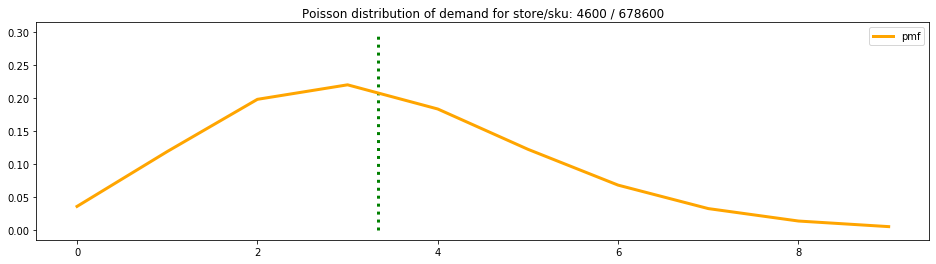

In [955]:
# EXAMPLE

plt.figure(figsize=(16,4))
lambda_temp = get_lambda(store_data, 4600, 678600)
plt.plot(stats.poisson.pmf(np.arange(10), lambda_temp), label='pmf', color='orange', linewidth=3);
plt.title('Poisson distribution of demand for store/sku: {} / {}'.format(4600, 678600)); plt.legend();
plt.vlines(lambda_temp, ymin=0, ymax=0.3, linestyle='dotted', color='green', linewidth=3);

In [956]:
def fetch_lambda(LOC, SKU):
    return lambdas[(lambdas['sku'] == SKU) & (lambdas['loc'] == LOC)]['lambda'].values[0]

In [957]:
def get_demand(LAMBDA, size=1):
    return np.random.poisson(LAMBDA, size=size).astype(int)

<h3>Recover demand</h3>

In [958]:
def recover_demand(df, LOC, SKU):
    sku_one = df[(df['sku'] == SKU) & (df['loc'] == LOC)]['sold']
    sku_one = sku_one.reindex(pd.date_range(np.min(sku_one.index), np.max(sku_one.index)))
    
    sku_one[sku_one.isna()] = get_demand(fetch_lambda(LOC, SKU), sku_one.isna().sum())
    
    sku_one = sku_one.rename('demand')
    return sku_one

In [959]:
# top sku
store_data['sku'].value_counts()[:5]

720600     1071
1934800    1050
2011600    1047
5559900    1040
582700      989
Name: sku, dtype: int64

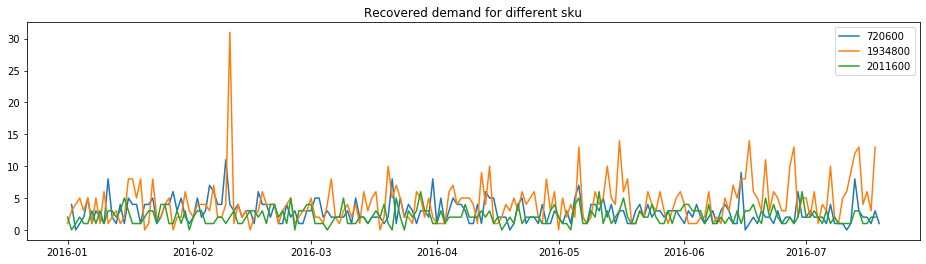

In [960]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Example

plt.figure(figsize=(16,4));
plt.plot(recover_demand(store_data, 4600, 720600).iloc[:200], label='720600');
plt.plot(recover_demand(store_data, 4600, 1934800).iloc[:200], label='1934800');
plt.plot(recover_demand(store_data, 4600, 2011600).iloc[:200], label='2011600');
plt.title('Recovered demand for different sku'); plt.legend();

<h3>Environment</h3>

In [961]:
class Env:
    def __init__(self, act_space=0, obs_space=0):
        self.action_space = act_space
        self.observation_space = obs_space
        
        self.state = None
        self.i = 0 # index for current day

    # initialize states
    def init_zero_state(self, df, LOC, SKU):
        self.state = pd.DataFrame(recover_demand(df, LOC, SKU))
        self.state.loc[:, 'stock'] = 0
        self.state['day_n'] = self.state.index.dayofweek
        
    # start from day == INDX
    def reset(self, indx=0):
        self.i = indx
        # return first observation or the one that is requested
        return self.state.iloc[self.i].values
    
    # this function is for debugging purposes only
    def action_sample(self):
        return np.random.poisson(2.0, size=self.action_space).astype(int)
    
    #
    def get_reward(self, sold):
        # reward is 0 at best, usually negative
        # sales - stock at the start of the day
        
        # at least one in stock
        return sold - self.state.iloc[self.i].stock * ((1-0.9)/0.8)
    
    #
    def get_sales(self):
        curr = self.state.iloc[self.i]
        return min(curr.demand, curr.stock)
        
    def step(self, action):
        # how much was sold that day
        sold = self.get_sales()
        # calculate the reward
        reward = self.get_reward(sold)
        
        # move to the next day
        self.i += 1
        # calculate stock for the next day
        
        # sold items
        self.state['stock'].iat[self.i] = self.state.iloc[self.i-1].stock - sold
        # refill
        
        # ------- #
        
        #RUL, OUL = action
        
        #if self.state.iloc[self.i].stock <= int(RUL):
        #    self.state['stock'].iat[self.i] = int(OUL)
        
        # ------- #
        
        # for num_actions == 1
        self.state['stock'].iat[self.i] = self.state.iloc[self.i-1].stock - sold + int(action[0])
        
        # return: observation, reward, done
        return self.state.iloc[self.i].values, reward, self.i >= self.state.shape[0]-1

<h3>Agent</h3>

In [962]:
import tensorflow as tf
from tensorflow.keras import layers

In [978]:
num_states = 3
num_actions = 1

upper_bound = 20
lower_bound = 0 #[0, 1] # ROL, OUL 


print("Size of State Space ->  {}".format(num_states))
print("Size of Action Space ->  {}".format(num_actions))

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  3
Size of Action Space ->  1
Max Value of Action ->  20
Min Value of Action ->  0


<h4>Exploration noise</h4>

In [979]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

<h4>Buffer</h4>

In [992]:
# Buffer stores experiences, when the capacity is exceeded, it starts overriding past data

class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

<h4>Actor + Critic</h4>

In [993]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(num_actions, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

<h4>Policy (take action)</h4>

In [994]:
def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_actions = np.clip(sampled_actions, lower_bound, upper_bound)

    if num_actions == 1:
        return [np.squeeze(legal_actions)]
    else:
        return legal_actions

<h4>Initialize agent</h4>

In [995]:
std_dev = 0.3
ou_noise = OUActionNoise(mean=np.zeros(num_actions), std_deviation=float(std_dev) * np.ones(num_actions))

# init actor
actor_model = get_actor()
critic_model = get_critic()

# init critic
target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_optimizer = tf.keras.optimizers.Adam(lr=0.002)
actor_optimizer = tf.keras.optimizers.Adam(lr=0.001)

total_episodes = 8
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(50000, 64) # capacity, batch_size

<h4>Initialize environment</h4>

In [996]:
# init environment
env = Env(num_actions, num_states)
# init zeros for "stock" values for loc/sku pair
env.init_zero_state(store_data, 4600, 720600)

<h4>Simulate</h4>

In [997]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 5 min to train
for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    while True:
        
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        state, reward, done = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        # End this episode when `done` is True
        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last N episodes
    avg_reward = np.mean(ep_reward_list[-5:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

Episode * 0 * Avg Reward is ==> -1566336.2499999998
Episode * 1 * Avg Reward is ==> -782664.9999999999
Episode * 2 * Avg Reward is ==> -521097.74999999994
Episode * 3 * Avg Reward is ==> -390727.68749999994
Episode * 4 * Avg Reward is ==> -312494.74999999994
Episode * 5 * Avg Reward is ==> 841.3
Episode * 6 * Avg Reward is ==> 735.475
Episode * 7 * Avg Reward is ==> 396.275


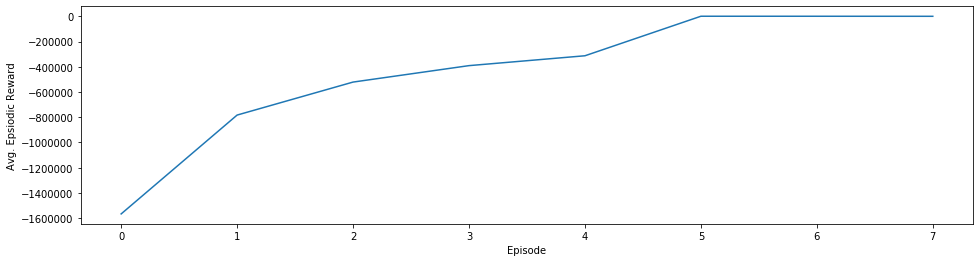

In [998]:
# Plotting graph
# Episodes versus Avg. Rewards
plt.figure(figsize=(16,4));
plt.plot(avg_reward_list);
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

<h2>Validation</h2>

In [999]:
# init environment
env = Env(num_actions, num_states)
# init start state "stock" values for loc/sku pair
env.init_zero_state(store_data, 4600, 720600)

In [1000]:
# VALIDATION

total_reward = 0
action_history = []


start_day_n = 0
#move to observation
prev_state = env.reset(start_day_n)

done = False
while not done:
    
    tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
    
    # get action
    action = policy(tf_prev_state, lambda: 0) # noise = 0 on validation
    # Recieve state and reward from environment.
    state, reward, done = env.step(action)
    # update total reward
    total_reward += reward
    
    #print(action, 'demand, stock:', prev_state)
    
    action_history.append(action[0])
    
    
    prev_state = state
    
print(total_reward)

338.875


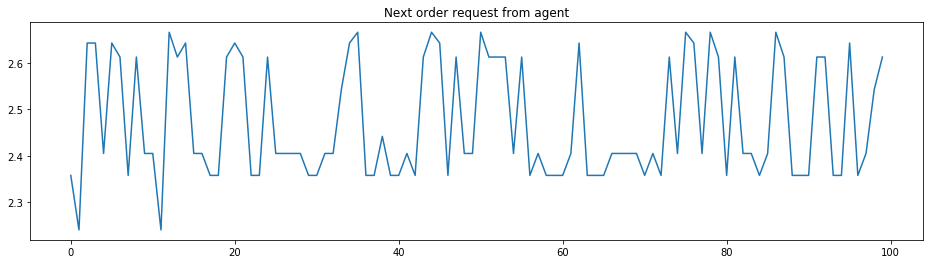

In [1001]:
action_history = np.array(action_history)
plt.figure(figsize=(16,4))
plt.plot(action_history[~(action_history == 0)][:100])
plt.title('Next order request from agent');